In [44]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split, Subset, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
import os
import shutil
import random

Process Data

In [45]:
transform = transforms.Compose([
    transforms.Resize((160, 160)),  
    transforms.ToTensor(), 
])

augmentation = transforms.Compose([
    # transforms.Resize((160, 160)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomResizedCrop(160, scale=(0.8, 1.0)),
    transforms.RandomAffine(degrees=0, shear=(0.2, 0.2), translate=(0.2, 0.2)),
    transforms.RandomRotation(degrees=(0, 360)),
    transforms.ToTensor()
])

In [46]:
T2I = transforms.ToPILImage()

Train size:  5958
Val size:  1000
test size:  2993


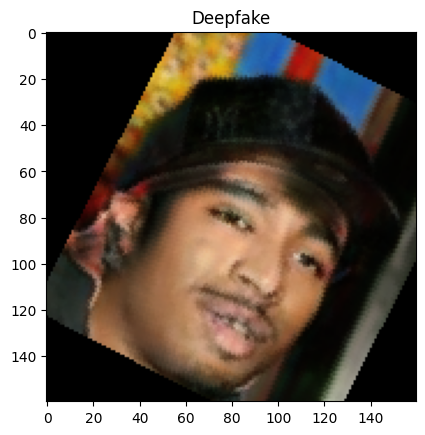

In [51]:
TRAIN_DIR = "train_val_test_datasets/train/"
VAL_DIR = "train_val_test_datasets/val/"
TEST_DIR = "train_val_test_datasets/test/"

train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=augmentation)
val_dataset = datasets.ImageFolder(root=VAL_DIR, transform=transform)
test_dataset = datasets.ImageFolder(root=TEST_DIR, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


print("Train size: ", len(train_dataset))
print("Val size: ", len(val_dataset))
print("test size: ", len(test_dataset))
for image, label in train_loader:
    image = image[0] # get first image in batch
    label = label[0]
    image = T2I(image)
    plt.imshow(image)
    label_name = "Deepfake" if label.numpy() == 0 else "Real"
    plt.title(label_name)
    break




### Define Custom MobileNet
